In [269]:
import gravity_analysis.io.loaders as l
import gravity_analysis.geography.fluxes as f
import gravity_analysis.plot.map as pm
import gravity_analysis.plot.heatmap as ph

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from importlib import reload

In [78]:
city = 'marseille'

In [79]:
hex_path = f'/home/apache/Citychrone/{city}/geometric_hexagons.geojson'
hexcover = gpd.read_file(hex_path)


In [22]:
# Load Trajs
reload(l)
loader = l.DaskTrajLoaderFrance(city='marseille')
trajs = loader.load_trajs()

In [43]:
df = trajs.get_partition(0)

In [ ]:
# Compute Fluxes 
reload(f)
fluxes = f.ComputeFluxes()
aggs = fluxes.get_fluxdf(trajs)

In [176]:
# Creat matrix of the heatmap
reload(f)
heatmapper = f.FluxesHeatmap(metric="trip_count")
heatmap = heatmapper.get_heatmap(aggs,hexcover)

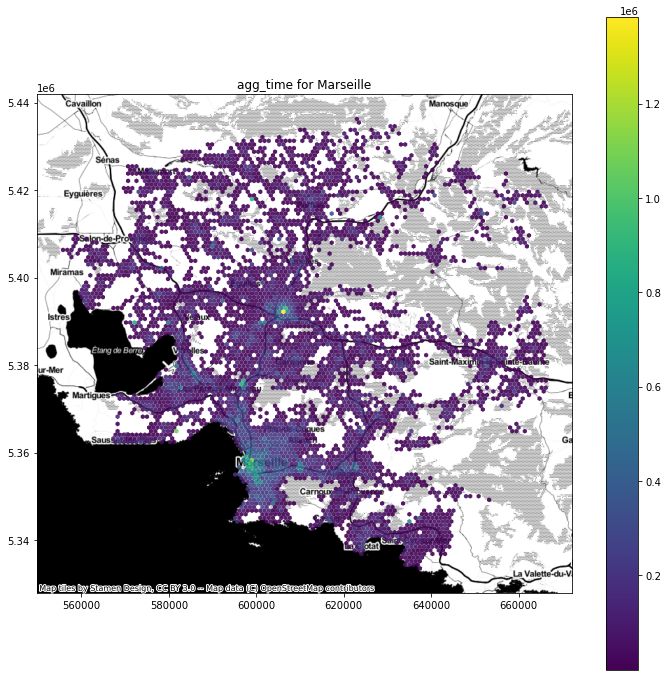

In [215]:
reload(pm)
plotcover = pd.merge(hexcover,aggs.drop('grid_id_i',axis=1).groupby('grid_id_f').sum().reset_index(), left_on='grid_id',right_on='grid_id_f')
#plotcover['agg_time'] = plotcover.agg_time.clip(0,10000)
#plotcover.plot(column='agg_time',legend=True,figsize=(10,10))
plotter = pm.HexcoverPlot()
plotter.plot_hexcover(plotcover, city, 'agg_time')

### Aggregate fluxed by zone 

In [225]:
## Experimental code
reload(l)
CLUST_DIR = '/home/apache/quinzeMinutes/analisi_claudio/graph_clustering'
clustcover = l.HexLoader(CLUST_DIR,f'hexcover_clusters_{city}.geojson').load_hexes()

In [ ]:
reload(f)
nl_aggs = f.ReaggregateFluxes(new_level='cluster').get_reaggr_fluxes()

In [234]:
#aggs = aggs.merge(clustcover[['grid_id','cluster']], left_on='grid_id_i',right_on='grid_id')\
#           .rename({'cluster' : 'cluster_i'},axis=1)\
#           .drop('grid_id',axis=1)\
#           .merge(clustcover[['grid_id','cluster']], left_on='grid_id_f',right_on='grid_id')\
#           .rename({'cluster' : 'cluster_f'},axis=1)\
#           .drop('grid_id',axis=1)
#aggs = aggs.groupby(['cluster_i','cluster_f'])['trip_count', 'agg_time', 'agg_space'].sum().reset_index()

In [253]:
reload(f)
heatmapper = f.FluxesHeatmap(metric="trip_count",level="cluster")
heatmap = heatmapper.get_heatmap(aggs,clustcover)

In [281]:
#aggs.query("cluster_i != cluster_f").sort_values("trip_count")

In [310]:
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

crs = 'EPSG:3857'

In [297]:
vorcover = hexcover.to_crs(crs)
vorcover['centroid'] = vorcover.geometry.apply(lambda g: g.centroid)
vorcover['dummy'] = 1
vorbounds = vorcover.dissolve('dummy')

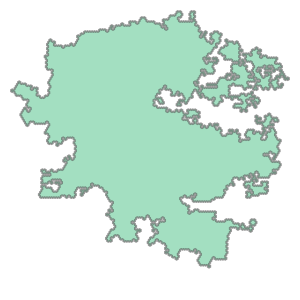

In [360]:
Polygon(vorbounds.exterior.geometry.values[0])

In [361]:
boundary_shape = cascaded_union(Polygon(vorbounds.exterior.geometry.values[0]))
coords = points_to_coords(vorcover.sample(100).centroid)


In [362]:
#poly_shapes, pts, poly_to_pt_assignments 
poly_shapes,poly_to_pt_assignments= voronoi_regions_from_coords(coords, boundary_shape)

<AxesSubplot:>

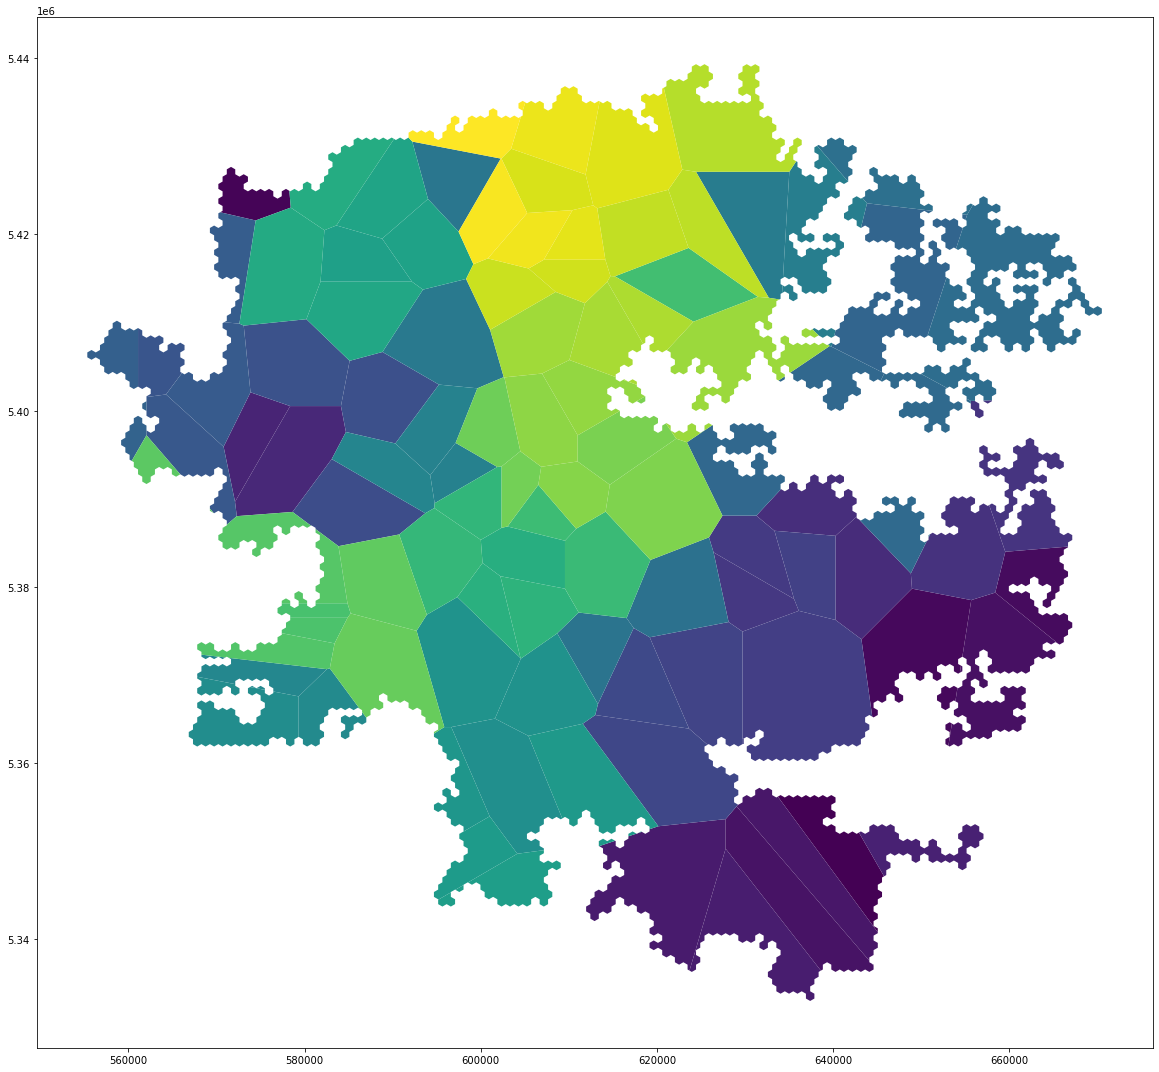

In [363]:
voronoi = gpd.GeoDataFrame(index=poly_shapes.keys(), geometry=list(poly_shapes.values()))
voronoi['n'] = voronoi.index
voronoi.plot(column='n',figsize=(20,20))

In [ ]:
fig, ax = subplot_for_map()
plot_voronoi_polys_with_points_in_area(ax, boundary_shape, poly_shapes, pts, poly_to_pt_assignments)
plt.show()

<AxesSubplot:>

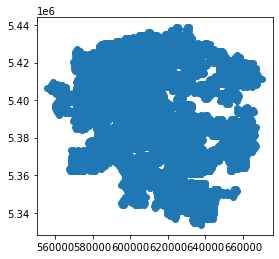

In [294]:
vorcover.centroid.plot()